# Milestone 1 Assignment - Capstone Proposal

## Authors:
* Kenji Oman
* Kyle Slyngstad
* Tsun Tsai

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import astral
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from IPython.display import display, Markdown

# Data Cleanup
## Traffic Data

In [2]:
%cd ..
df_raw = pd.read_csv('KenjiOman-Traffic_Violations.csv.gz')
%cd GroupMembers/

/home/koman/UW_Data_Science_Certificate/Class3/Programming_Assignments


/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/home/koman/UW_Data_Science_Certificate/Class3/Programming_Assignments/GroupMembers


In [3]:
# Map 'Charge' to 'Title' and 'Subtitle' categories.
chargeMapping = pd.read_csv('ChargeListFinal.csv')

In [4]:
df = pd.merge(df_raw, chargeMapping, how='left', on='Charge')
df.shape

(1292399, 37)

In [5]:
# Looking at
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292399 entries, 0 to 1292398
Data columns (total 37 columns):
Date Of Stop               1292399 non-null object
Time Of Stop               1292399 non-null object
Agency                     1292399 non-null object
SubAgency                  1292389 non-null object
Description                1292390 non-null object
Location                   1292397 non-null object
Latitude                   1197045 non-null float64
Longitude                  1197045 non-null float64
Accident                   1292399 non-null object
Belts                      1292399 non-null object
Personal Injury            1292399 non-null object
Property Damage            1292399 non-null object
Fatal                      1292399 non-null object
Commercial License         1292399 non-null object
HAZMAT                     1292399 non-null object
Commercial Vehicle         1292399 non-null object
Alcohol                    1292399 non-null object
Work Zone         

We see that there are a fair number of missing values in Latitude and Longitude (95,354, to be exact), but considering how we have 1,292,399 rows total, and we don't want to try to parse the Location column, let's just drop these rows.

In [6]:
# Dropped the 'Geolocation', 'Location', 'Driver City', and 'Description' columns
# Dropped Charge and aggregated by 'Title' and 'Subtitle' 
# Dropped Accident and Agency columns because they're all the same value

df = df.drop(['Geolocation','Location','Driver City','Description','Agency','Accident','Charge'], axis = 1)

In [7]:
# Drop rows without a Latitude/ Longitude
df = df[~(df.Latitude.isnull() | df.Longitude.isnull())]

In [8]:
# Fix remaining Latutude/ Longitude
# First, let's look at summary stats for these two
df[['Latitude', 'Longitude']].describe()

,Latitude,Longitude
count,1.197045e+06,1.197045e+06
mean,3.907435e+01,-7.710341e+01
std,1.062592e+00,9.588788e-01
min,-9.461099e+01,-1.512560e+02
25%,3.903149e+01,-7.719467e+01
50%,3.907336e+01,-7.709332e+01
75%,3.913867e+01,-7.704381e+01
max,7.718716e+01,4.151207e+01


In [9]:
# And, if latitude is not negative, and longitude is not positive
# (get a better idea of the distribution of real data)
df.loc[(df.Latitude > 0) & (df.Longitude < 0), ['Latitude', 'Longitude']].describe()

,Latitude,Longitude
count,1.196965e+06,1.196965e+06
mean,3.908288e+01,-7.711117e+01
std,8.718474e-02,1.434665e-01
min,4.514500e+00,-1.512560e+02
25%,3.903150e+01,-7.719468e+01
50%,3.907337e+01,-7.709332e+01
75%,3.913868e+01,-7.704382e+01
max,4.154316e+01,-7.345018e+01


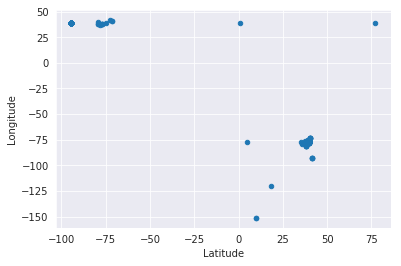

In [10]:
# A scatterplot of all values
df.loc[:, ['Latitude', 'Longitude']].plot.scatter(x='Latitude', y='Longitude')
plt.show()

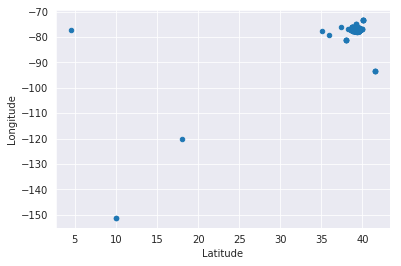

In [11]:
# And, a scatterplot for these "more real" values
df.loc[(df.Latitude > 0) & (df.Longitude < 0), ['Latitude', 'Longitude']].plot.scatter(x='Latitude', y='Longitude')
plt.show()

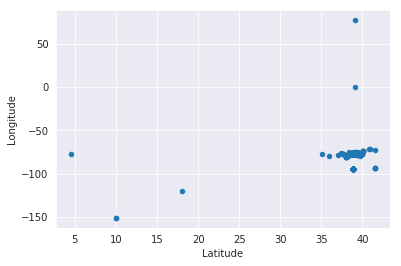

In [12]:
# Even in the "cleaner" data, we have some outliers.  But, for the full data, we
# can definitely clean up some.  All positive longitude values look like they should
# be lattitude (since they are hovering about 35, which is where the rest of the latitude
# values sit).  So, let's first clean those
df.loc[df.Longitude > 0, ['Latitude', 'Longitude']] = df.loc[df.Longitude > 0, ['Latitude', 'Longitude']]\
    .rename(columns={'Latitude': 'Longitude', 'Longitude': 'Latitude'})

# And, make the plot again
df.loc[:, ['Latitude', 'Longitude']].plot.scatter(x='Latitude', y='Longitude')
plt.show()

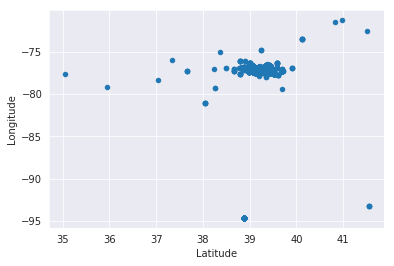

In [13]:
# So, we still have some outliers.  Let's take a look at them explicitly
# First, grab the "good" data
good_mask = (df.Latitude > 30) & (df.Longitude < -50) & (df.Longitude > -100)

# Make sure that we got all the good data
df.loc[good_mask, ['Latitude', 'Longitude']].plot.scatter(x='Latitude', y='Longitude')
plt.show()

In [14]:
# Now, look at the not-good data
df.loc[~good_mask, ['Latitude', 'Longitude']]

,Latitude,Longitude
630287,18.060598,-120.384670
718470,10.040743,-151.255987
718471,10.040743,-151.255987
1266897,39.064435,0.583333
1269710,39.140408,77.187162
1280986,4.514500,-77.203063


In [15]:
# We see one (index = 1269710) that looks like
# the longitude is encoded without it's negative sign, but
# otherwise, is good.  All other Latitude/ Longitude values
# are far enough off that I would say these are mis-encoded, so
# let's just drop them
df.loc[1269710, 'Longitude'] = -1 * df.loc[1269710, 'Longitude']

# Make the mask again
good_mask = (df.Latitude > 30) & (df.Longitude < -50) & (df.Longitude > -100)
# And look at the data again to make sure we got what we want
df.loc[~good_mask, ['Latitude', 'Longitude']]

,Latitude,Longitude
630287,18.060598,-120.384670
718470,10.040743,-151.255987
718471,10.040743,-151.255987
1266897,39.064435,0.583333
1280986,4.514500,-77.203063


In [16]:
# Looks good, so let's drop these not good rows
df = df[good_mask]

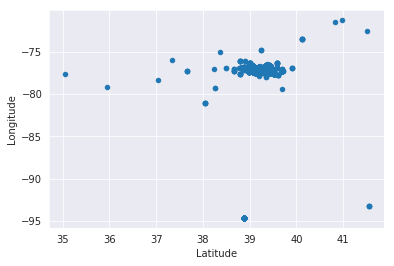

In [17]:
# Take another peak at this distribution of Lat/Long
df.loc[:, ['Latitude', 'Longitude']].plot.scatter(x='Latitude', y='Longitude')
plt.show()

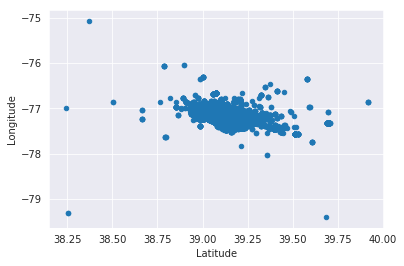

In [18]:
# Things out in longitude < -90 are out in Illinois or further, so those
# can't be right. Maryland itself only goes out to -79.47 longitude,
# so let's drop anything past -80. On the other side,
# Mayrland extends out to about -75. For longitude,
# Maryland has the range (37.9, 39.7), so let's use near that to
# make some cutoffs
df = df.loc[(df.Latitude >= 37.9) & (df.Latitude <= 40) & (df.Longitude >= -80) & (df.Longitude <= -75)]
df.loc[:, ['Latitude', 'Longitude']].plot.scatter(x='Latitude', y='Longitude')
plt.show()

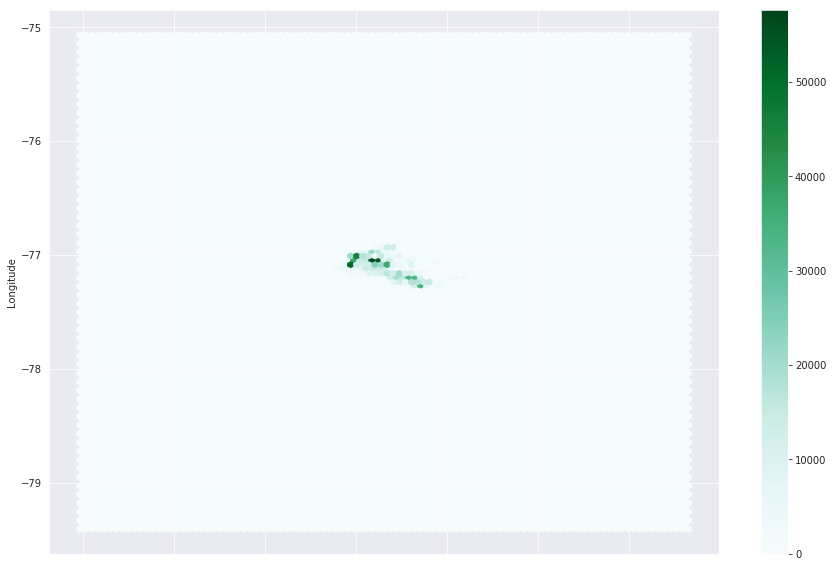

In [19]:
# Just to see the density, let's do a hexbin (it would be interesting if we could
# overlay this on a map, but that's for another day) In any case, looks good enough
df.loc[:, ['Latitude', 'Longitude']].plot.hexbin(x='Latitude', y='Longitude', figsize=(15,10))
plt.show()

In [20]:
#For columns with text values yes and no, convert to 0's and 1's.
df['Alcohol'] = df['Alcohol'].map(dict(Yes=1, No=0))
df['Belts'] = df['Belts'].map(dict(Yes=1, No=0))
df['Commercial License'] = df['Commercial License'].map(dict(Yes=1, No=0))
df['Commercial Vehicle'] = df['Commercial Vehicle'].map(dict(Yes=1, No=0))
df['Contributed To Accident'] = df['Contributed To Accident'].map(dict(Yes=1, No=0))
df['Fatal'] = df['Fatal'].map(dict(Yes=1, No=0))
df['Personal Injury'] = df['Personal Injury'].map(dict(Yes=1, No=0))
df['Property Damage'] = df['Property Damage'].map(dict(Yes=1, No=0))
df['HAZMAT'] = df['HAZMAT'].map(dict(Yes=1, No=0))
df['Work Zone'] = df['Work Zone'].map(dict(Yes=1, No=0))
# 'Article' column is either 'Transportation Article', 'Maryland Rules', or Null. Convert to 0 and 1 and -1.
df.loc[df['Article'].isnull(),'Article'] = -1
df.loc[df['Article'] == 'Maryland Rules','Article'] = 1
df.loc[df['Article'] == 'Transportation Article','Article'] = 0
# Update 'Color' to replace blanks with 'NONE'
df.loc[df['Color'].isnull(),'Color'] = 'Unknown'
# Update 'Year' to replace blanks with '-1'
df.loc[df['Year'].isnull(),'Year'] = -1

#SubAgency
df.loc[df["SubAgency"] == "Headquarters and Special Operations", "SubAgency"] = "districtHQ"
df.loc[df["SubAgency"] == "1st district, Rockville", "SubAgency"] = "district1"
df.loc[df["SubAgency"] == "2nd district, Bethesda", "SubAgency"] = "district2"
df.loc[df["SubAgency"] == "3rd district, Silver Spring", "SubAgency"] = "district3"
df.loc[df["SubAgency"] == "4th district, Wheaton", "SubAgency"] = "district4"
df.loc[df["SubAgency"] == "5th district, Germantown", "SubAgency"] = "district5"
df.loc[df["SubAgency"] == "6th district, Gaithersburg / Montgomery Village", "SubAgency"] = "district6"
df.loc[~df["SubAgency"].isin(["districtHQ", 
                                              "district1",
                                              "district2",
                                              "district3",
                                              "district4",
                                              "district5",
                                              "district6"                                              
                                             ]), "SubAgency"] = "Unknown"

In [21]:
# Looks like we need to convert the date/time columns
print(df[['Date Of Stop', 'Time Of Stop']].dtypes)
df[['Date Of Stop', 'Time Of Stop']].head()

Date Of Stop    object
Time Of Stop    object
dtype: object


,Date Of Stop,Time Of Stop
1,08/29/2017,10:19:00
2,12/01/2014,12:52:00
3,08/29/2017,09:22:00
6,10/08/2013,13:23:00
10,02/14/2014,20:10:00


In [22]:
# Before that, let's remove spaces from all our column names
cols = ['_'.join(x.split()) for x in df.columns]
df.columns = cols

In [23]:
# Now, convert to date/time columns
df['DateTime_of_Stop'] = pd.to_datetime(df.Date_Of_Stop + ' ' + df.Time_Of_Stop, infer_datetime_format=True)
# And move this column to the front
df = df[['DateTime_of_Stop'] + df.iloc[:, :-1].columns.tolist()]
df.head()

,DateTime_of_Stop,Date_Of_Stop,Time_Of_Stop,SubAgency,Latitude,Longitude,Belts,Personal_Injury,Property_Damage,Fatal,...,Violation_Type,Article,Contributed_To_Accident,Race,Gender,Driver_State,DL_State,Arrest_Type,ChargeTitle,ChargeSubtitle
1,2017-08-29 10:19:00,08/29/2017,10:19:00,district2,38.981725,-77.092757,0,0,0,0,...,Citation,0,0,WHITE,F,VA,VA,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices
2,2014-12-01 12:52:00,12/01/2014,12:52:00,district6,39.162888,-77.229088,0,0,1,0,...,Citation,0,0,BLACK,F,MD,MD,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices
3,2017-08-29 09:22:00,08/29/2017,09:22:00,district3,39.056975,-76.954633,0,0,1,0,...,Citation,0,0,BLACK,M,MD,MD,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices
6,2013-10-08 13:23:00,10/08/2013,13:23:00,district4,39.093383,-77.079552,0,0,0,0,...,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Vehicle Registration,Improper Registration Plates
10,2014-02-14 20:10:00,02/14/2014,20:10:00,district1,39.234843,-77.281540,0,0,0,0,...,Citation,0,0,WHITE,M,MD,WV,A - Marked Patrol,Rules of Road,Wrong Side of Road


In [24]:
#Check for Columns with Null values
for i in range(len(df.columns)):
    print(df.columns[i],":",str(df.iloc[:,i].isnull().sum()))

DateTime_of_Stop : 0
Date_Of_Stop : 0
Time_Of_Stop : 0
SubAgency : 0
Latitude : 0
Longitude : 0
Belts : 0
Personal_Injury : 0
Property_Damage : 0
Fatal : 0
Commercial_License : 0
HAZMAT : 0
Commercial_Vehicle : 0
Alcohol : 0
Work_Zone : 0
State : 54
VehicleType : 0
Year : 0
Make : 56
Model : 170
Color : 0
Violation_Type : 0
Article : 0
Contributed_To_Accident : 0
Race : 0
Gender : 0
Driver_State : 9
DL_State : 778
Arrest_Type : 0
ChargeTitle : 0
ChargeSubtitle : 0


Leaving 'Arrest Type', 'State', 'Driver State', 'DL State', 'Date Of Stop', 'Time of Stop', 'Violation Type' (Maybe merge 'ESERO' and 'SERO' values), 'Race' and 'Gender',  columns alone. These columns can be aggregated into various ways based on the needs.

## Weather Data
Instead of cleaning it again, I'll just directly pull my cleaned dataset (see my notebook for how this was done)

In [25]:
weather_df = pd.read_csv('../KenjiOman-CleanedMontgomeryCOWeather2012-2018.csv.gz', parse_dates=['DATE'])
weather_df.head()

,DATE,Precipitation,Snow,SnowDepth,MaxTemp,MinTemp,GroundSnowWaterEquivalent,SnowFallWaterEquivalent,Fog,Thunder,SleetIceSnowPellets,Hail,GlazeRime,HighWinds
0,2011-12-31,0.1,0.000000,0.0,54.0,40.0,0.0,0.0,0,0,0,0,0,0
1,2012-01-01,0.1,0.000000,0.0,53.0,36.0,0.0,0.0,0,0,0,0,0,0
2,2012-01-02,0.2,0.000000,0.0,47.0,32.0,0.0,0.0,0,0,0,0,0,0
3,2012-01-03,0.0,0.158114,0.0,29.0,17.0,0.0,0.0,0,0,0,0,0,0
4,2012-01-04,0.0,0.077460,0.0,29.0,10.0,0.0,0.0,0,0,0,0,0,0


In [26]:
# We indeed have DATE as a date/time column
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291 entries, 0 to 2290
Data columns (total 14 columns):
DATE                         2291 non-null datetime64[ns]
Precipitation                2291 non-null float64
Snow                         2291 non-null float64
SnowDepth                    2291 non-null float64
MaxTemp                      2291 non-null float64
MinTemp                      2291 non-null float64
GroundSnowWaterEquivalent    2291 non-null float64
SnowFallWaterEquivalent      2291 non-null float64
Fog                          2291 non-null int64
Thunder                      2291 non-null int64
SleetIceSnowPellets          2291 non-null int64
Hail                         2291 non-null int64
GlazeRime                    2291 non-null int64
HighWinds                    2291 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(6)
memory usage: 250.7 KB


In [27]:
# Merge this with the traffic data
# First, need to convert the traffic data's Date_Of_Stop
# to date/time
df['Date_Of_Stop'] = df.DateTime_of_Stop.dt.date
# And set weather date column, with similarly encoded date
weather_df['date'] = weather_df.DATE.dt.date
# Merge, but do inner -- found there were 7,783 records that didn't
# have any weather observations, for some reason (maybe a blackout??)
df = df.merge(weather_df, left_on='Date_Of_Stop', right_on='date', how='inner')
# Now, drop the 'date' and 'DATE' columns
df.drop(columns=['date', 'DATE'], inplace=True)
with pd.option_context('max_columns', 1000):
    display(df.head())

,DateTime_of_Stop,Date_Of_Stop,Time_Of_Stop,SubAgency,Latitude,Longitude,Belts,Personal_Injury,Property_Damage,Fatal,Commercial_License,HAZMAT,Commercial_Vehicle,Alcohol,Work_Zone,State,VehicleType,Year,Make,Model,Color,Violation_Type,Article,Contributed_To_Accident,Race,Gender,Driver_State,DL_State,Arrest_Type,ChargeTitle,ChargeSubtitle,Precipitation,Snow,SnowDepth,MaxTemp,MinTemp,GroundSnowWaterEquivalent,SnowFallWaterEquivalent,Fog,Thunder,SleetIceSnowPellets,Hail,GlazeRime,HighWinds
0,2017-08-29 10:19:00,2017-08-29,10:19:00,district2,38.981725,-77.092757,0,0,0,0,0,0,0,0,0,VA,02 - Automobile,2001.0,TOYOTA,COROLLA,GREEN,Citation,0,0,WHITE,F,VA,VA,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0
1,2017-08-29 09:22:00,2017-08-29,09:22:00,district3,39.056975,-76.954633,0,0,1,0,0,0,0,0,0,MD,02 - Automobile,1998.0,DODG,DAKOTA,WHITE,Citation,0,0,BLACK,M,MD,MD,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0
2,2017-08-29 01:56:00,2017-08-29,01:56:00,district6,39.123242,-77.232998,0,0,0,0,0,0,0,0,0,MD,05 - Light Duty Truck,2005.0,FORD,ESCAPE,RED,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Licensing,Driving without Proper License,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0
3,2017-08-29 01:56:00,2017-08-29,01:56:00,district6,39.123242,-77.232998,0,0,0,0,0,0,0,0,0,MD,05 - Light Duty Truck,2005.0,FORD,ESCAPE,RED,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Licensing,Driving without Proper License,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0
4,2017-08-29 05:21:00,2017-08-29,05:21:00,district4,39.135682,-76.994878,0,0,0,0,0,0,0,0,0,MD,02 - Automobile,2001.0,FORD,EXPLORER,BLACK,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0


In [28]:
# Check to make sure we don't have any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189162 entries, 0 to 1189161
Data columns (total 44 columns):
DateTime_of_Stop             1189162 non-null datetime64[ns]
Date_Of_Stop                 1189162 non-null object
Time_Of_Stop                 1189162 non-null object
SubAgency                    1189162 non-null object
Latitude                     1189162 non-null float64
Longitude                    1189162 non-null float64
Belts                        1189162 non-null int64
Personal_Injury              1189162 non-null int64
Property_Damage              1189162 non-null int64
Fatal                        1189162 non-null int64
Commercial_License           1189162 non-null int64
HAZMAT                       1189162 non-null int64
Commercial_Vehicle           1189162 non-null int64
Alcohol                      1189162 non-null int64
Work_Zone                    1189162 non-null int64
State                        1189108 non-null object
VehicleType                  1189162 n

## Daylight
Now, let's bring in the daylight values (instead of re-creating the work, I'll just pull in the generated data directly)

In [29]:
# Grab the generated data
daylight_df = pd.read_csv('../KenjiOman-M01_daylight.csv.gz', parse_dates=['DateTime'], infer_datetime_format=True)
daylight_df.head()

,DateTime,daylight
0,2013-09-24 17:11:00,day
1,2017-08-29 10:19:00,day
2,2014-12-01 12:52:00,day
3,2017-08-29 09:22:00,day
4,2017-08-28 23:41:00,night


In [30]:
# Check types
daylight_df.dtypes

DateTime    datetime64[ns]
daylight            object
dtype: object

In [31]:
# Now, merge with the traffic data, and take a look
df = df.merge(daylight_df, left_on='DateTime_of_Stop', right_on='DateTime', how='left')
df.drop(columns=['DateTime'], inplace=True)
with pd.option_context('max_columns', 10000):
    display(df.head())

,DateTime_of_Stop,Date_Of_Stop,Time_Of_Stop,SubAgency,Latitude,Longitude,Belts,Personal_Injury,Property_Damage,Fatal,Commercial_License,HAZMAT,Commercial_Vehicle,Alcohol,Work_Zone,State,VehicleType,Year,Make,Model,Color,Violation_Type,Article,Contributed_To_Accident,Race,Gender,Driver_State,DL_State,Arrest_Type,ChargeTitle,ChargeSubtitle,Precipitation,Snow,SnowDepth,MaxTemp,MinTemp,GroundSnowWaterEquivalent,SnowFallWaterEquivalent,Fog,Thunder,SleetIceSnowPellets,Hail,GlazeRime,HighWinds,daylight
0,2017-08-29 10:19:00,2017-08-29,10:19:00,district2,38.981725,-77.092757,0,0,0,0,0,0,0,0,0,VA,02 - Automobile,2001.0,TOYOTA,COROLLA,GREEN,Citation,0,0,WHITE,F,VA,VA,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0,day
1,2017-08-29 09:22:00,2017-08-29,09:22:00,district3,39.056975,-76.954633,0,0,1,0,0,0,0,0,0,MD,02 - Automobile,1998.0,DODG,DAKOTA,WHITE,Citation,0,0,BLACK,M,MD,MD,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0,day
2,2017-08-29 01:56:00,2017-08-29,01:56:00,district6,39.123242,-77.232998,0,0,0,0,0,0,0,0,0,MD,05 - Light Duty Truck,2005.0,FORD,ESCAPE,RED,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Licensing,Driving without Proper License,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0,night
3,2017-08-29 01:56:00,2017-08-29,01:56:00,district6,39.123242,-77.232998,0,0,0,0,0,0,0,0,0,MD,05 - Light Duty Truck,2005.0,FORD,ESCAPE,RED,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Licensing,Driving without Proper License,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0,night
4,2017-08-29 05:21:00,2017-08-29,05:21:00,district4,39.135682,-76.994878,0,0,0,0,0,0,0,0,0,MD,02 - Automobile,2001.0,FORD,EXPLORER,BLACK,Citation,0,0,HISPANIC,M,MD,MD,A - Marked Patrol,Rules of Road,Failure to Obey Traffic Control Devices,0.5,0.0,0.0,63.0,58.0,0.0,0.0,0,0,0,0,0,0,night


In [32]:
# Also, check for missing values
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189162 entries, 0 to 1189161
Data columns (total 45 columns):
DateTime_of_Stop             1189162 non-null datetime64[ns]
Date_Of_Stop                 1189162 non-null object
Time_Of_Stop                 1189162 non-null object
SubAgency                    1189162 non-null object
Latitude                     1189162 non-null float64
Longitude                    1189162 non-null float64
Belts                        1189162 non-null int64
Personal_Injury              1189162 non-null int64
Property_Damage              1189162 non-null int64
Fatal                        1189162 non-null int64
Commercial_License           1189162 non-null int64
HAZMAT                       1189162 non-null int64
Commercial_Vehicle           1189162 non-null int64
Alcohol                      1189162 non-null int64
Work_Zone                    1189162 non-null int64
State                        1189108 non-null object
VehicleType                  1189162 n

# Data Out
We are done merging the different datasets, so let's now output this as a csv file (compressed)

In [33]:
# Output the data
df.to_csv('KenjiKyleTsun-M01-MergedData.csv.gz', index=False, compression='gzip')